<a href="https://colab.research.google.com/github/DJCordhose/ai/blob/master/docs/img/football/embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
!pip install -q tf-nightly-gpu-2.0-preview

     |████████████████████████████████| 378.8MB 56kB/s 
     |████████████████████████████████| 4.1MB 48.4MB/s 
     |████████████████████████████████| 450kB 56.2MB/s 
     |████████████████████████████████| 61kB 28.7MB/s 


In [15]:
import tensorflow as tf
print(tf.__version__)

2.0.0-dev20190726


In [1]:
!curl https://raw.githubusercontent.com/DJCordhose/ai/master//docs/img/football/playerData.json -O

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 22224  100 22224    0     0  77978      0 --:--:-- --:--:-- --:--:-- 77978


In [0]:
import pandas as pd

In [0]:
df = pd.read_json('playerData.json')

In [3]:
df.head()

,Assists,BallControlPhases,CardsRed,CardsYellow,CardsYellowRed,CrossesNotSuccessfulSum,CrossesSuccessfulSum,CrossesSum,FoulsAgainstOpponent,FreeKicksSum,GoalContribution,MatchMinutes,OwnGoals,PassesNotSuccessfulSum,PassesSuccessfulSum,PassesSum,PenaltiesNotSuccessful,PenaltiesSuccessful,ShotsAtGoalSuccessfull,ShotsAtGoalSum,SubstitutionsIn,SubstitutionsOut,TacklingGamesAirLost,TacklingGamesAirSum,TacklingGamesAirWon,TacklingGamesGroundLost,TacklingGamesGroundSum,TacklingGamesGroundWon,TacklingGamesLost,TacklingGamesSum,TacklingGamesWon,name
0,7,1149,0,4,0,6,3,9,35,0,24,2931,0,187,464,651,0,4,17,68,1,7,124,255,131,278,555,277,402,810,408,Wout Weghorst
1,7,1137,0,2,0,8,2,10,23,10,29,2959,0,136,538,674,0,3,22,141,0,2,89,147,58,257,508,251,346,655,309,Robert Lewandowski
2,0,398,0,0,0,3,0,3,4,12,18,1203,0,59,172,231,0,1,18,52,15,8,37,49,12,72,132,60,109,181,72,Francisco Alcacer Garcia
3,4,1382,0,2,0,32,10,42,6,23,21,2403,0,159,747,906,0,5,17,107,2,10,23,31,8,172,315,143,195,346,151,Andrej Kramaric
4,8,1407,1,3,0,16,3,19,31,26,25,2322,0,155,805,960,0,3,17,70,0,5,42,60,18,280,496,216,322,556,234,Marco Reus


In [4]:
df.describe()

,Assists,BallControlPhases,CardsRed,CardsYellow,CardsYellowRed,CrossesNotSuccessfulSum,CrossesSuccessfulSum,CrossesSum,FoulsAgainstOpponent,FreeKicksSum,GoalContribution,MatchMinutes,OwnGoals,PassesNotSuccessfulSum,PassesSuccessfulSum,PassesSum,PenaltiesNotSuccessful,PenaltiesSuccessful,ShotsAtGoalSuccessfull,ShotsAtGoalSum,SubstitutionsIn,SubstitutionsOut,TacklingGamesAirLost,TacklingGamesAirSum,TacklingGamesAirWon,TacklingGamesGroundLost,TacklingGamesGroundSum,TacklingGamesGroundWon,TacklingGamesLost,TacklingGamesSum,TacklingGamesWon
count,21.000000,21.000000,21.000000,21.000000,21.0,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.0,21.000000,21.000000,21.000000,21.0,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000
mean,5.761905,1838.761905,0.047619,2.809524,0.0,25.714286,8.333333,34.047619,28.238095,6.571429,15.761905,2596.857143,0.0,181.619048,1111.571429,1293.190476,0.0,1.047619,10.000000,56.619048,2.333333,5.285714,63.428571,124.666667,61.238095,231.904762,464.000000,232.095238,295.333333,588.666667,293.333333
std,4.134063,744.234970,0.218218,1.778175,0.0,32.287990,10.360180,41.843131,16.364305,8.096737,8.859485,426.209137,0.0,61.286602,698.593127,692.366422,0.0,1.657594,6.920983,34.999252,3.623994,4.417498,44.528161,94.223316,52.604092,86.430842,148.997315,72.241889,114.848741,199.795979,96.974395
min,0.000000,398.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,4.000000,0.000000,1.000000,1203.000000,0.0,59.000000,172.000000,231.000000,0.0,0.000000,1.000000,7.000000,0.000000,0.000000,23.000000,28.000000,4.000000,72.000000,132.000000,60.000000,109.000000,181.000000,72.000000
25%,3.000000,1231.000000,0.000000,2.000000,0.0,5.000000,2.000000,6.000000,17.000000,0.000000,8.000000,2408.000000,0.0,136.000000,538.000000,705.000000,0.0,0.000000,2.000000,25.000000,0.000000,2.000000,37.000000,62.000000,31.000000,174.000000,430.000000,185.000000,209.000000,513.000000,238.000000
50%,6.000000,1813.000000,0.000000,3.000000,0.0,14.000000,3.000000,16.000000,26.000000,3.000000,18.000000,2625.000000,0.0,183.000000,867.000000,1094.000000,0.0,0.000000,11.000000,52.000000,1.000000,5.000000,45.000000,104.000000,53.000000,257.000000,500.000000,254.000000,294.000000,562.000000,309.000000
75%,9.000000,2325.000000,0.000000,4.000000,0.0,30.000000,10.000000,42.000000,41.000000,12.000000,23.000000,2931.000000,0.0,222.000000,1656.000000,1761.000000,0.0,3.000000,16.000000,70.000000,2.000000,8.000000,73.000000,147.000000,79.000000,282.000000,555.000000,277.000000,376.000000,728.000000,356.000000
max,14.000000,3369.000000,1.000000,7.000000,0.0,126.000000,31.000000,157.000000,70.000000,26.000000,29.000000,3060.000000,0.0,316.000000,2336.000000,2468.000000,0.0,5.000000,22.000000,141.000000,15.000000,16.000000,182.000000,375.000000,205.000000,361.000000,651.000000,341.000000,543.000000,985.000000,459.000000


In [0]:
Y_raw = df.drop('name', axis=1).values

In [48]:
names = df['name'].values
names

array(['Wout Weghorst', 'Robert Lewandowski', 'Francisco Alcacer Garcia',
       'Andrej Kramaric', 'Marco Reus', 'Timo Werner',
       'Yussuf Yurary Poulsen', 'Kevin Volland', 'Max Kruse',
       'Sébastien Haller', 'Thiago Alcantara Nascimiento',
       'Jadon Malik Sancho', 'Axel Laurent Angel Lambert Witsel',
       'Maximilian Eggestein', 'Ondrej Duda', 'Filip Kostic',
       'Joshua Walter Kimmich', 'Nico Elvedi', 'Niklas Süle',
       'Manuel Obafemi Akanji', 'Hans Carl Ludwig Augustinsson'],
      dtype=object)

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

In [0]:
column_trans = ColumnTransformer([], remainder=StandardScaler())

In [0]:
Y_std = column_trans.fit_transform(Y_raw)

In [0]:
pca = PCA()

In [10]:
pca.fit(Y_std)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [11]:
pca.explained_variance_ratio_

array([3.23569252e-01, 2.35491343e-01, 1.72310853e-01, 6.44901303e-02,
       5.73144216e-02, 4.14522282e-02, 3.51623488e-02, 2.25588821e-02,
       1.36785243e-02, 9.36401220e-03, 7.69074616e-03, 6.97337242e-03,
       3.58341305e-03, 2.88768200e-03, 1.74741538e-03, 7.27534136e-04,
       6.15892579e-04, 2.22450239e-04, 1.46132923e-04, 1.33652351e-05,
       7.75919433e-34])

In [0]:
pca = PCA(n_components=10)
Y_std_pca = pca.fit_transform(Y_std)

In [0]:
Y = Y_std_pca
Y = Y.reshape(21, 1, 10)

In [15]:
import numpy as np

x = np.array(df.index)
x

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20])

## First we prove that the archtiecture can learn to reproduce the output as closely as desired

This makes sure that the embedding really becomes the bottleneck and not other parts of the model

In [24]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Embedding, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential, Model

embedding_dim = 10
n_players = len(x)
n_features = Y_std_pca.shape[1]

dropout = .4
recurrent_dropout = .4

model = Sequential()
model.add(Embedding(name='embedding',
                    input_dim=n_players, 
                    output_dim=embedding_dim, 
                    input_length=1))

model.add(Dense(units=500, name='hidden1', activation='tanh'))
# model.add(Dense(units=500, name='hidden2', activation='tanh'))

model.add(Dense(units=n_features, name='output', activation='linear'))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1, 10)             210       
_________________________________________________________________
hidden1 (Dense)              (None, 1, 500)            5500      
_________________________________________________________________
output (Dense)               (None, 1, 10)             5010      
Total params: 10,720
Trainable params: 10,720
Non-trainable params: 0
_________________________________________________________________


In [25]:
%%time

EPOCHS=1000
BATCH_SIZE=1

history = model.fit(x, Y, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)

CPU times: user 54 s, sys: 4.62 s, total: 58.6 s
Wall time: 41.1 s


In [26]:
loss = model.evaluate(x, Y, batch_size=BATCH_SIZE)
loss

21/21 [==============================] - 0s 2ms/sample - loss: 0.0057


0.005705705202195705

In [27]:
model.predict([0])

array([[[-3.4422538 ,  1.6716107 ,  2.079185  ,  0.17699035,
         -1.2062266 , -0.4907998 , -0.10023707,  0.9614762 ,
         -0.4125932 , -1.0654359 ]]], dtype=float32)

In [28]:
Y[0]

array([[-3.30090642,  1.68516618,  2.0386956 ,  0.19554894, -1.20204929,
        -0.46824384, -0.03543281,  0.93170634, -0.42159862, -1.0126599 ]])

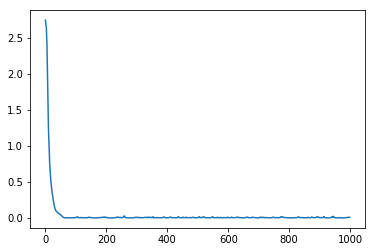

In [31]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])

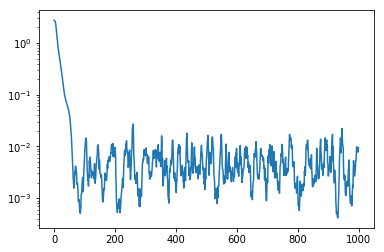

In [32]:
plt.yscale('log')
plt.plot(history.history['loss'])

## Next step is to reduce the embedding to 2 for visualization making it the bottle neck

In [34]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Embedding, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential, Model

embedding_dim = 2
n_players = len(x)
n_features = Y_std_pca.shape[1]

dropout = .4
recurrent_dropout = .4

model = Sequential()
model.add(Embedding(name='embedding',
                    input_dim=n_players, 
                    output_dim=embedding_dim, 
                    input_length=1))

model.add(Dense(units=500, name='hidden1', activation='tanh'))
# model.add(Dense(units=500, name='hidden2', activation='tanh'))

# model.add(BatchNormalization())
# model.add(Dropout(dropout))

model.add(Dense(units=n_features, name='output', activation='linear'))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1, 2)              42        
_________________________________________________________________
hidden1 (Dense)              (None, 1, 500)            1500      
_________________________________________________________________
output (Dense)               (None, 1, 10)             5010      
Total params: 6,552
Trainable params: 6,552
Non-trainable params: 0
_________________________________________________________________


In [35]:
%%time

EPOCHS=1000
BATCH_SIZE=1

history = model.fit(x, Y, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)

CPU times: user 51.5 s, sys: 4.64 s, total: 56.1 s
Wall time: 39.6 s


In [36]:
loss = model.evaluate(x, Y, batch_size=BATCH_SIZE)
loss

21/21 [==============================] - 0s 2ms/sample - loss: 1.1673


1.167291909456253

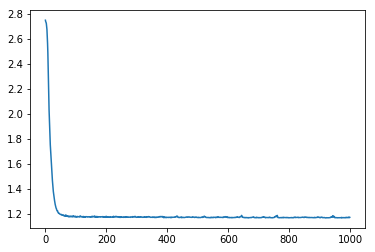

In [37]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])

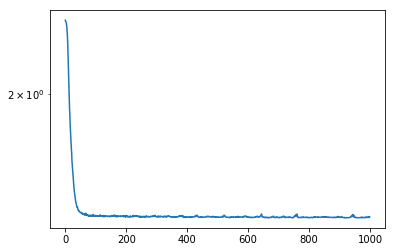

In [38]:
plt.yscale('log')
plt.plot(history.history['loss'])

In [39]:
model.predict([0])

array([[[-3.4752512e+00,  1.6962681e+00,  2.2568121e-03, -1.4656726e-02,
          2.4109099e-03,  2.3446290e-02,  2.1625613e-04,  2.0592946e-03,
         -1.5592053e-02,  6.3488161e-04]]], dtype=float32)

In [41]:
Y[0]

array([[-3.30090642,  1.68516618,  2.0386956 ,  0.19554894, -1.20204929,
        -0.46824384, -0.03543281,  0.93170634, -0.42159862, -1.0126599 ]])

In [0]:
embedding_layer = model.get_layer('embedding')
embedding_model = Model(inputs=model.input, outputs=embedding_layer.output)
embeddings_2d = embedding_model.predict(x).reshape(-1, 2)

In [53]:
embeddings_2d

array([[ 0.01543793, -0.15662982],
       [-0.05303513, -0.11802009],
       [-0.28480852,  0.04812402],
       [-0.12879182, -0.00898816],
       [-0.05998616, -0.07642719],
       [-0.06722812, -0.06278643],
       [ 0.04220625, -0.1799554 ],
       [ 0.04448588, -0.11530125],
       [ 0.03071012, -0.02425163],
       [ 0.00735086, -0.18003777],
       [ 0.08940241,  0.07263998],
       [-0.01932946, -0.02843947],
       [ 0.04593186,  0.10468779],
       [ 0.11155175, -0.02222137],
       [ 0.05675773, -0.09469292],
       [ 0.15799774, -0.08200477],
       [ 0.15449308,  0.07104841],
       [-0.01669041,  0.12730369],
       [ 0.00330097,  0.16952418],
       [-0.05387944,  0.15745774],
       [ 0.13562892,  0.01932435]], dtype=float32)

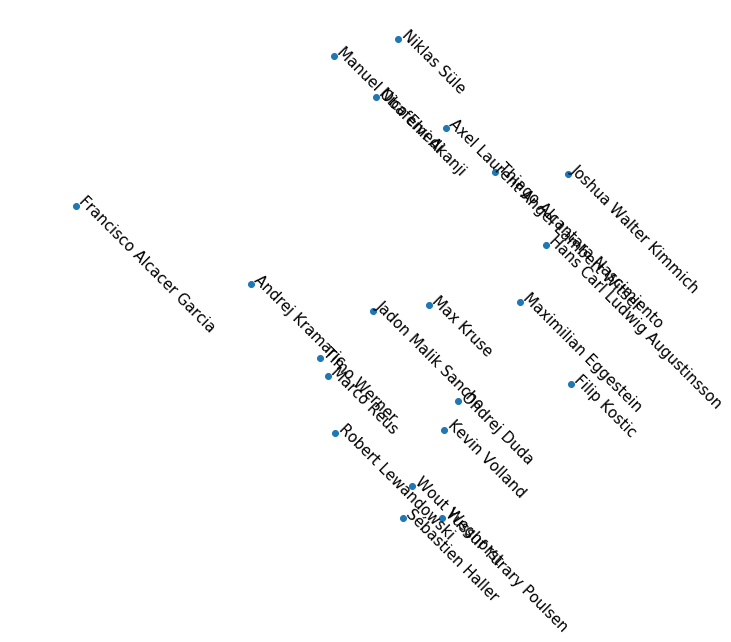

In [80]:
# for printing only
plt.figure(figsize=(10,10))
# plt.figure(dpi=600)
# plt.figure(dpi=300)

plt.axis('off')

plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
for name, x_pos, y_pos in zip(names, embeddings_2d[:, 0], embeddings_2d[:, 1]):
#   print(name, (x_pos, y_pos))
  plt.annotate(name, (x_pos, y_pos),  rotation=-45, size=15)

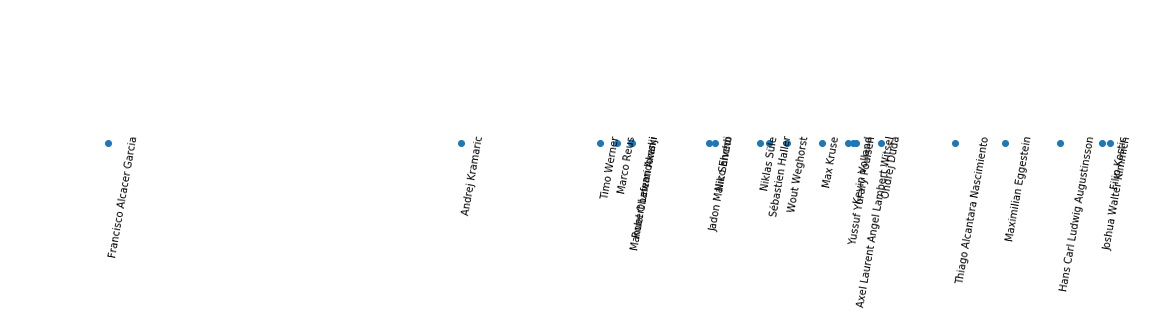

In [81]:
import numpy as np

embeddings_1d = embeddings_2d[:, 0]

# for printing only
plt.figure(figsize=(20,5))
# plt.figure(dpi=300)

plt.axis('off')

plt.scatter(embeddings_1d, np.zeros(len(embeddings_1d)))
for name, x_pos in zip(names, embeddings_1d):
  plt.annotate(name, (x_pos, 0), rotation=80)

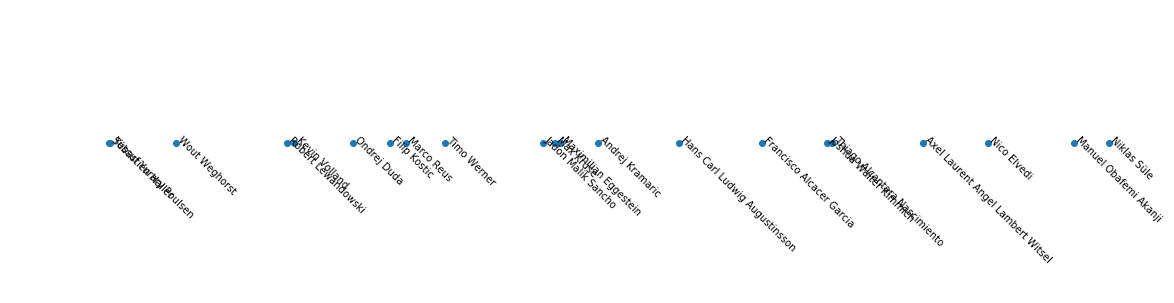

In [82]:
import numpy as np

embeddings_1d = embeddings_2d[:, 1]

# for printing only
plt.figure(figsize=(20,5))
# plt.figure(dpi=300)

plt.axis('off')

plt.scatter(embeddings_1d, np.zeros(len(embeddings_1d)))
for name, x_pos in zip(names, embeddings_1d):
  plt.annotate(name, (x_pos, 0), rotation=-45)

## All that looks horribly meaningless, let's try one dimension from the start and make it a bit harder but adding regularizaion and higher batch sizes

* the hope is that this forces the network to put more deliberation into the embedding
* also don't throw away any feature data

In [177]:
Y = Y_std
Y_std.shape

(21, 31)

In [0]:
# Y = Y_raw
# Y_std.shape

In [0]:
Y = Y.reshape(21, 1, 31)

In [205]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Embedding, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential, Model

embedding_dim = 1
n_players = len(x)
n_features = Y_std.shape[1]

dropout = .7

model = Sequential()
model.add(Embedding(name='embedding',
                    input_dim=n_players, 
                    output_dim=embedding_dim, 
                    input_length=1))

model.add(Dense(units=500, name='hidden1', activation='tanh'))
# model.add(Dense(units=500, name='hidden2', activation='tanh'))

# model.add(BatchNormalization())
# model.add(Dropout(dropout))

model.add(Dense(units=n_features, name='output', activation='linear'))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1, 1)              21        
_________________________________________________________________
hidden1 (Dense)              (None, 1, 500)            1000      
_________________________________________________________________
output (Dense)               (None, 1, 31)             15531     
Total params: 16,552
Trainable params: 16,552
Non-trainable params: 0
_________________________________________________________________


In [206]:
%%time

EPOCHS=200
BATCH_SIZE=5

history = model.fit(x, Y, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)

CPU times: user 2.87 s, sys: 308 ms, total: 3.18 s
Wall time: 2.41 s


In [207]:
loss = model.evaluate(x, Y, batch_size=BATCH_SIZE)
loss

21/21 [==============================] - 0s 2ms/sample - loss: 0.6130


0.6129772123836336

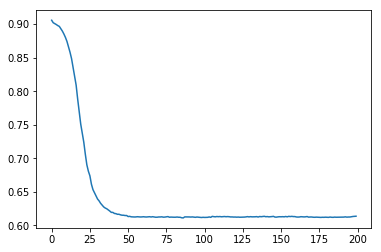

In [208]:
# plt.yscale('log')
plt.plot(history.history['loss'])

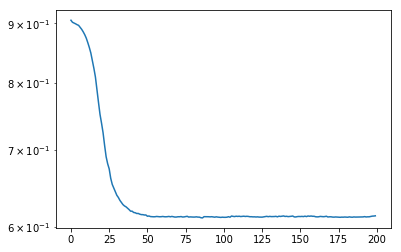

In [209]:
plt.yscale('log')
plt.plot(history.history['loss'])

In [0]:
embedding_layer = model.get_layer('embedding')
embedding_model = Model(inputs=model.input, outputs=embedding_layer.output)
embeddings_1d = embedding_model.predict(x).reshape(-1)

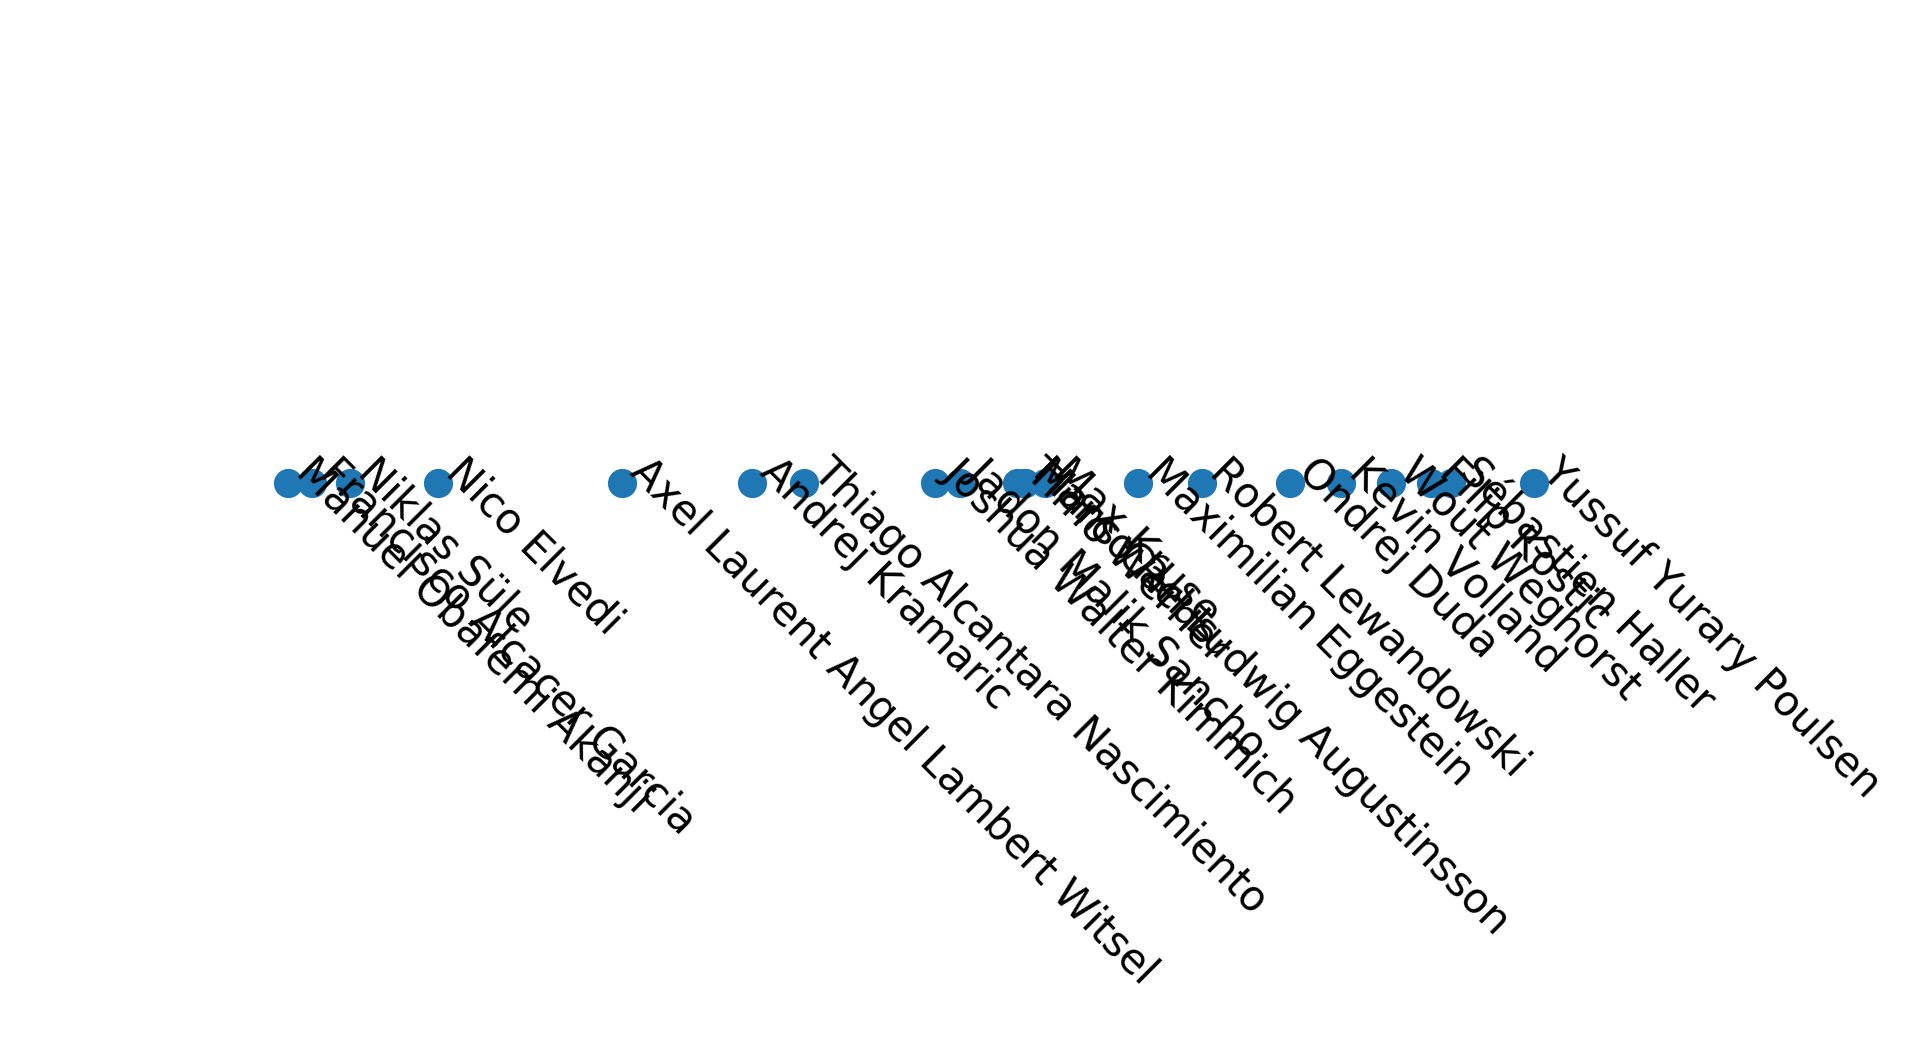

In [211]:
# for printing only
# plt.figure(figsize=(50,5))
plt.figure(dpi=300)

plt.axis('off')

plt.scatter(embeddings_1d, np.zeros(len(embeddings_1d)))
for name, x_pos in zip(names, embeddings_1d):
  plt.annotate(name, (x_pos, 0), rotation=-45)